- Почистить данные
- Провести EDA найти скоррелированные признаки
- Провести T-SNA найти какая категориальная переменная позволяет разделить данные лучшим образом
- Найти набор признаков, который позволяет получить наибольшее значение ROC-AUC

In [1]:
import pandas as pd
import sweetviz as sv
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("datasets/train.csv", index_col='id')
test = pd.read_csv("datasets/test.csv", index_col='id')
sample_submission = pd.read_csv("datasets/sample_submission.csv")
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [4]:
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol', 'gluc']
bool_cols = ['smoke', 'alco', 'active']
target = 'cardio'

In [5]:
for col in cat_cols:
    train[col] = train[col].astype('str')
    test[col] = test[col].astype('str')
    
for col in bool_cols:
    train[col] = train[col].astype('bool')
    test[col] = test[col].astype('bool')

In [6]:
print('Describe Train Numerical Columns')
display(train[num_cols].describe())
print('Describe Test Numerical Columns')
display(test.describe())

Describe Train Numerical Columns


,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


Describe Test Numerical Columns


,age,height,weight,ap_hi,ap_lo
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,19455.528400,164.322267,74.120615,130.271300,95.689000
std,2477.840922,8.213740,14.341540,212.501152,163.852598
min,8865.000000,50.000000,10.000000,-130.000000,-90.000000
25%,17658.000000,159.000000,65.000000,120.000000,80.000000
50%,19694.000000,165.000000,72.000000,120.000000,80.000000
75%,21320.000000,170.000000,82.000000,140.000000,90.000000
max,23705.000000,198.000000,183.000000,16020.000000,9100.000000


In [7]:
print('Train Duplicates')
display(train.duplicated().sum())
print('Test Duplicates')
display(test.duplicated().sum())

Train Duplicates


24

Test Duplicates


6

Предварительный анализ данных показал, что данные содержат дубликаты, выбросы и отрицательные значения. 
По этой причине необходимо провести предварительное преобразование:
- удалить дубликаты в тренировачном датасете (в тестовом не удалять)
- взять абсолютные значения для данных давления ['ap_hi', 'ap_lo'] в обоих наборах данных
- вычислить 2.5% и 97.5% квантили для всех количественных признаков тренировочного датасета. Данные ниже нижнего и выше верхнего квантилей приравнять к их значениям. Сделать это для тренировочного и тестового датасетов (использовать значения полученные на тренировочном наборе данных)
- значения из колонки 'age' разделим на 365 и поменяем тип данных на целочисленный

In [8]:
train = train.drop_duplicates()

train_out_corr = train.copy()
test_out_corr = test.copy()

train_out_corr[['ap_hi', 'ap_lo']] = np.abs(train_out_corr[['ap_hi', 'ap_lo']])
test_out_corr[['ap_hi', 'ap_lo']] = np.abs(test_out_corr[['ap_hi', 'ap_lo']])

QUANTILE_BOTTOM = 0.025
QUANTILE_UPPER = 0.975

for i in num_cols:

    qb = train[i].quantile(QUANTILE_BOTTOM)
    qu = train[i].quantile(QUANTILE_UPPER)

    def outlier_correction(col):
        if col < qb:
            return qb
        elif col > qu:
            return qu
        else:
            return col

    train_out_corr[i] = train_out_corr[i].apply(outlier_correction).astype('int64')
    test_out_corr[i] = test_out_corr[i].apply(outlier_correction).astype('int64')
    
train_out_corr['age'] = (train_out_corr['age'] / 365).astype('int64')
test_out_corr['age'] = (test_out_corr['age'] / 365).astype('int64')

Проведем исследовательский анализ данных с помощью пакета sweetviz

                                             |          | [  0%]   00:00 -> (? left)


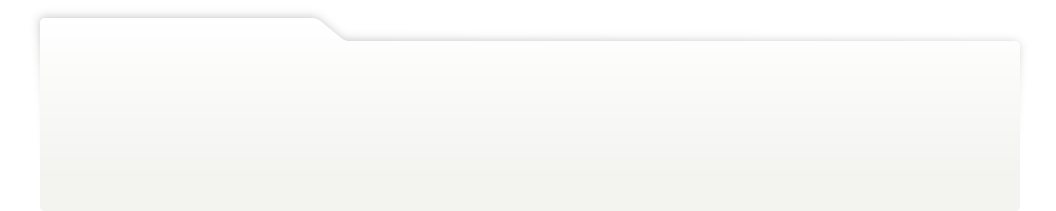
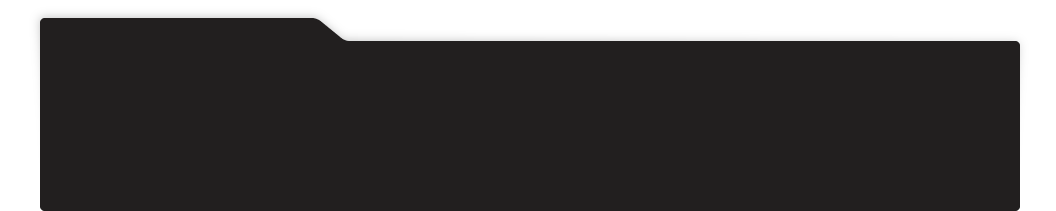
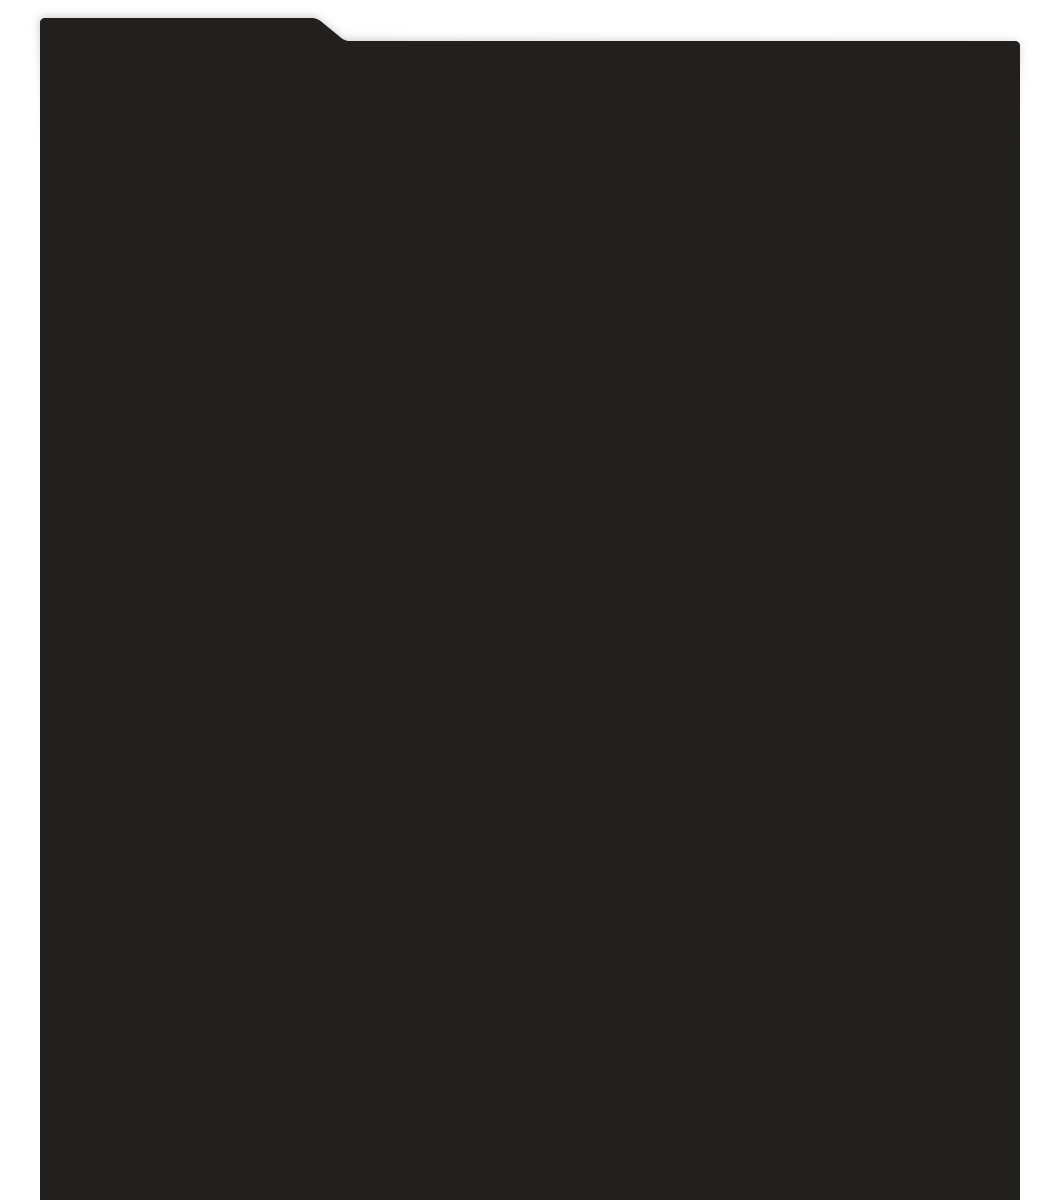
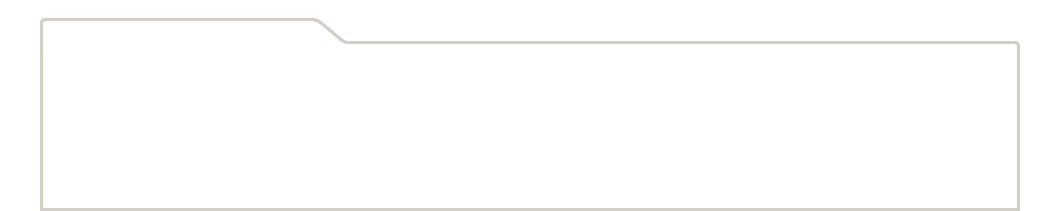
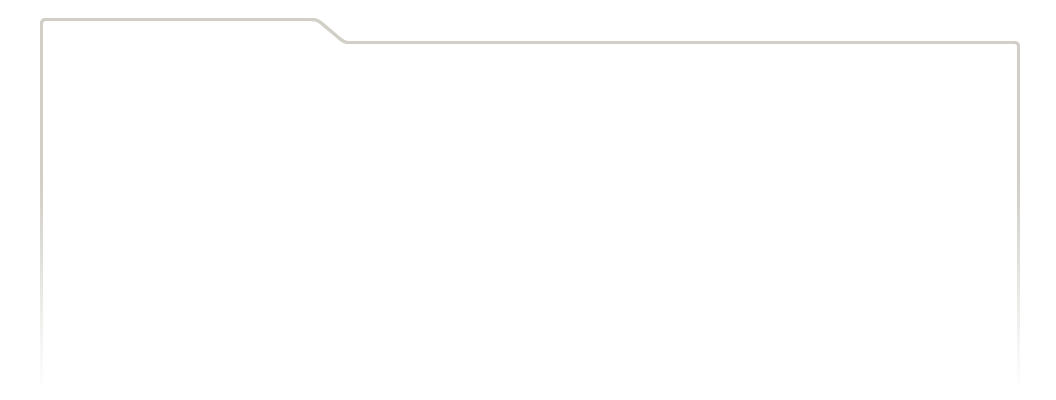
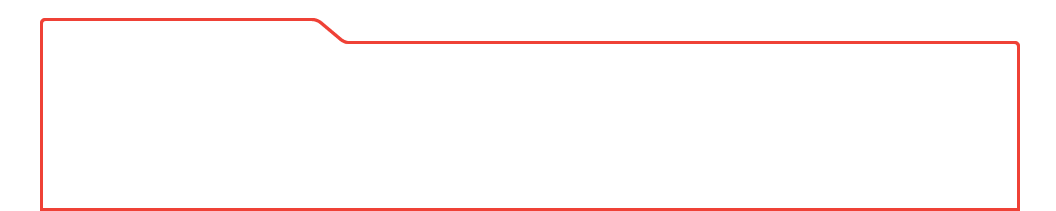
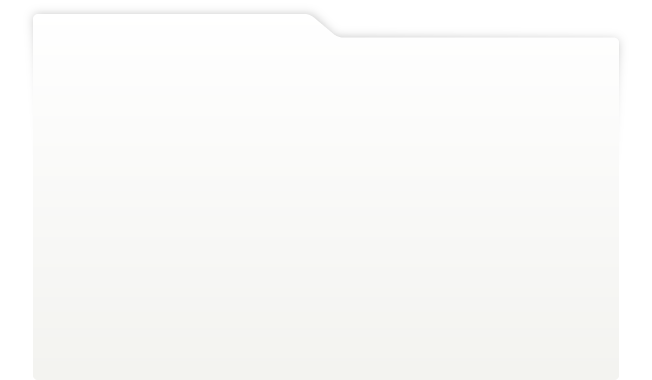
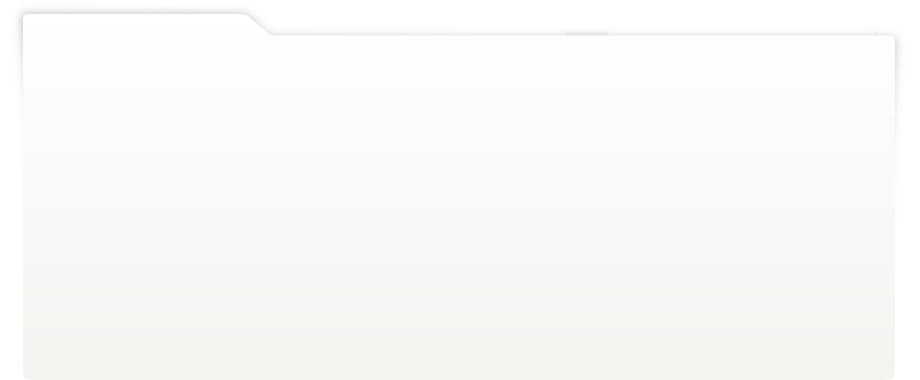
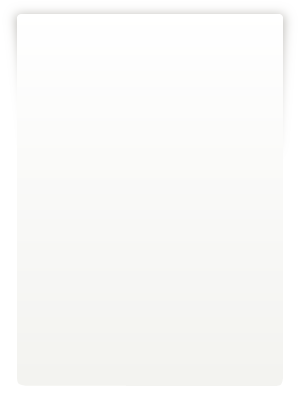
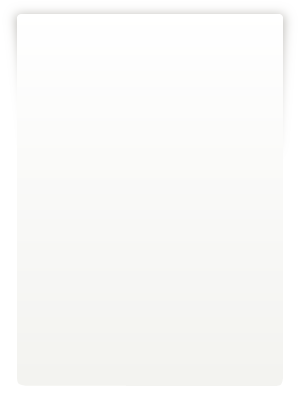
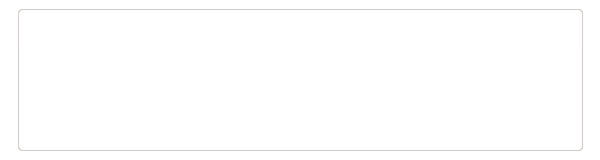
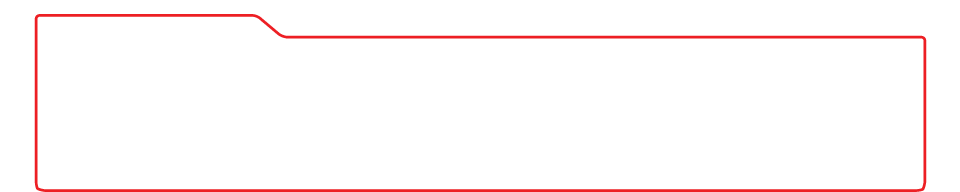
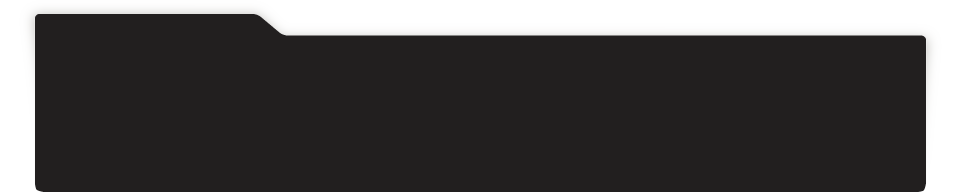
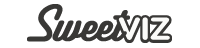
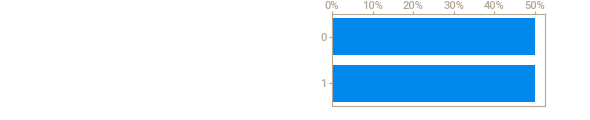
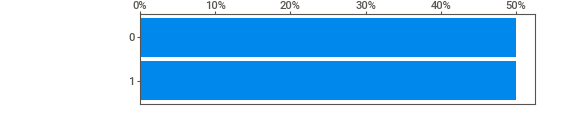
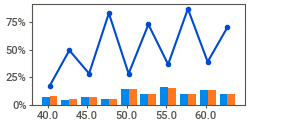
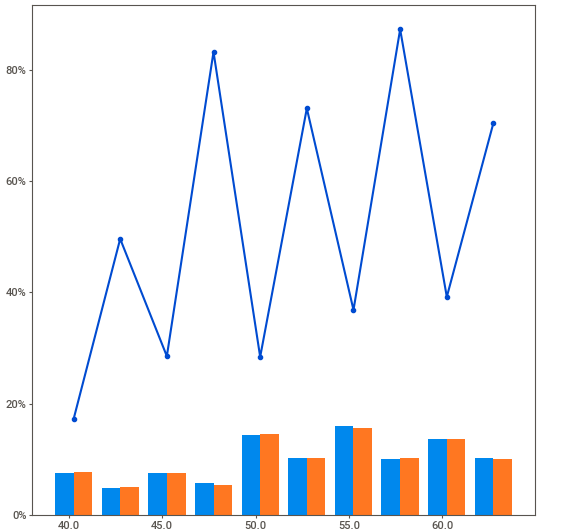
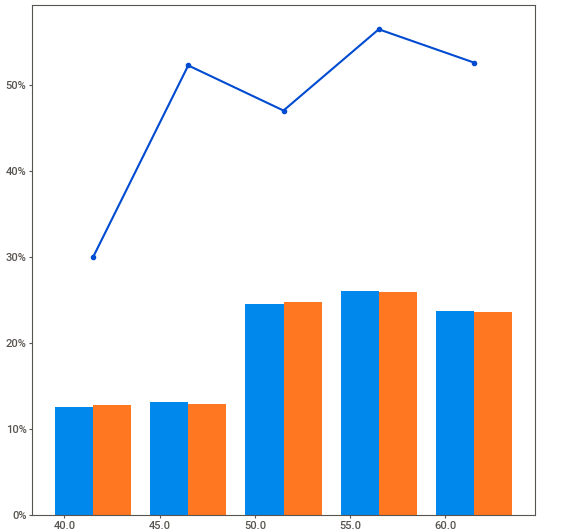
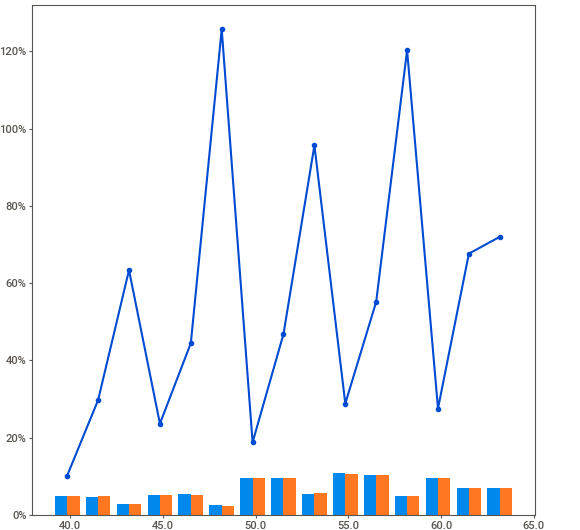
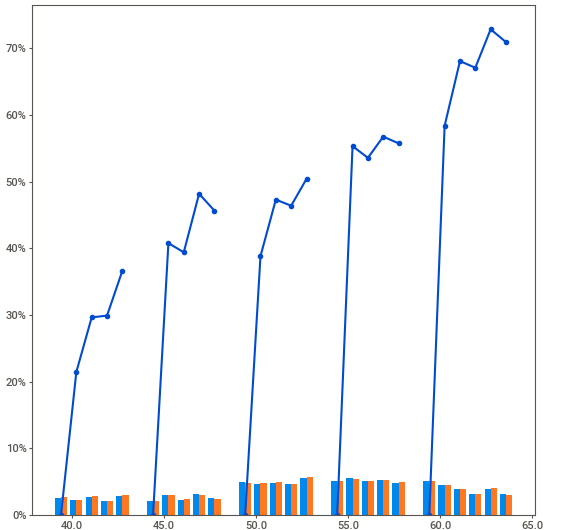
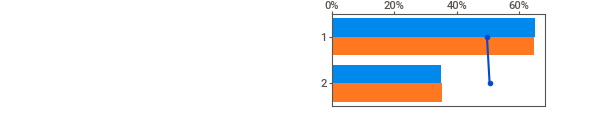
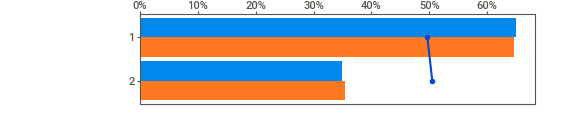
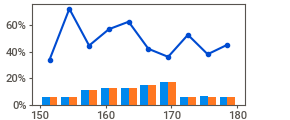
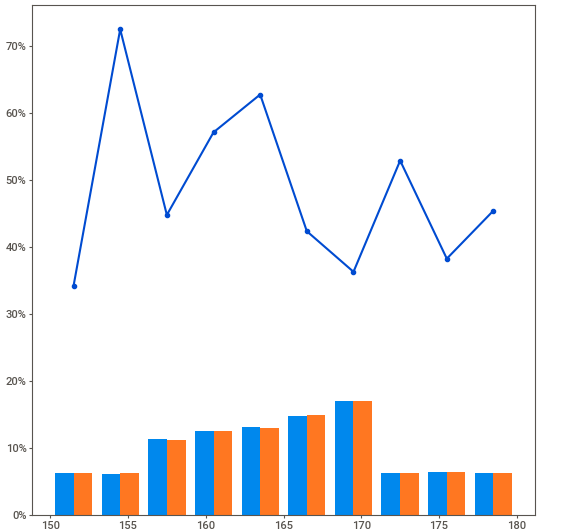
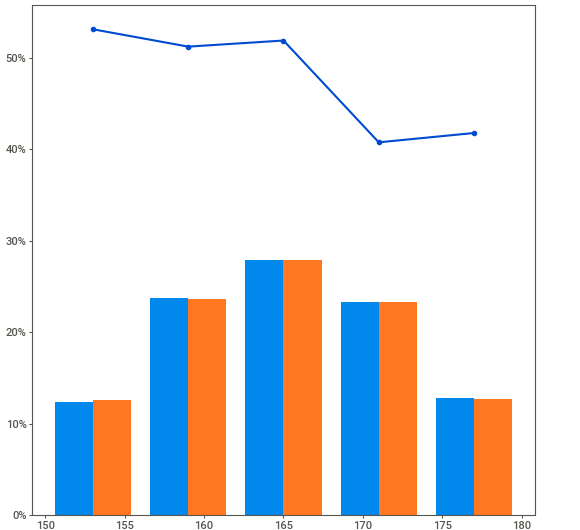
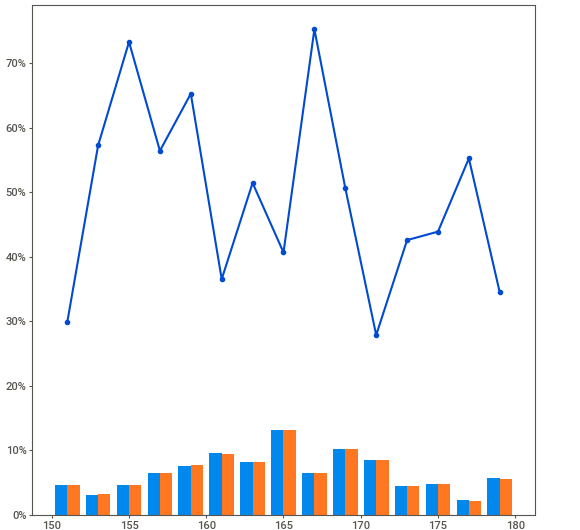
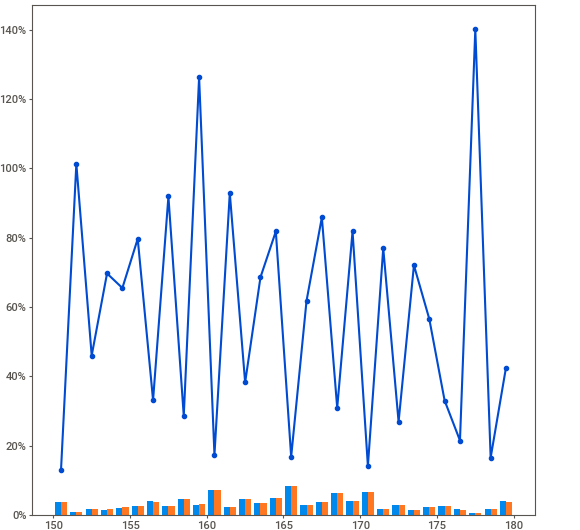
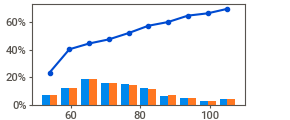
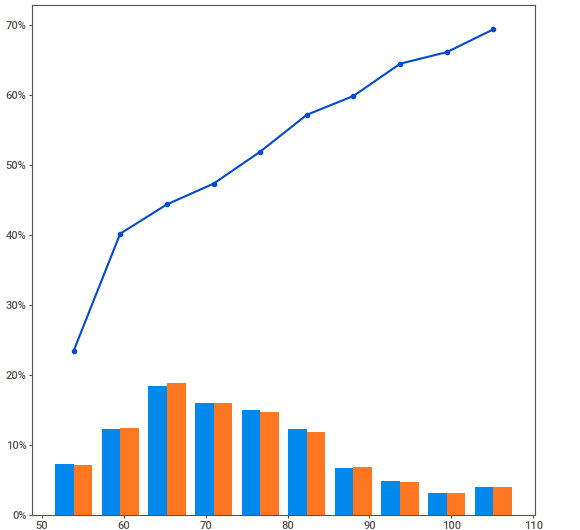
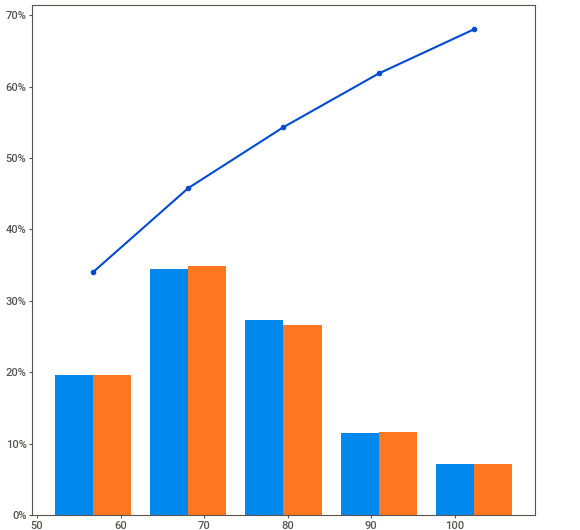
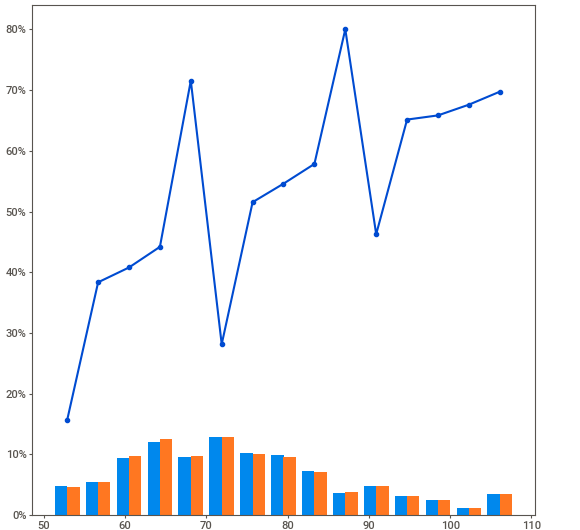
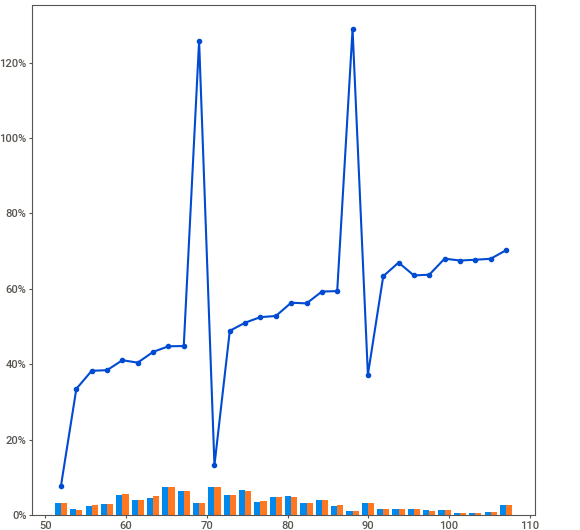
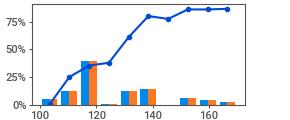
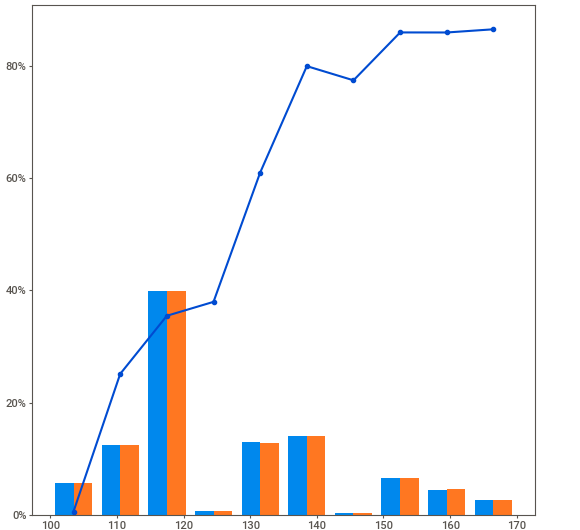
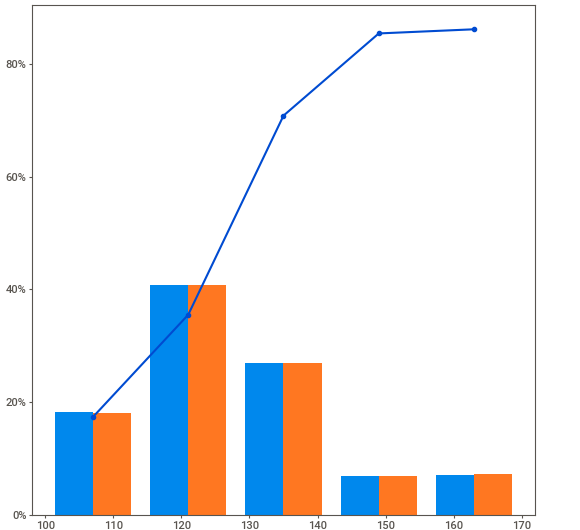
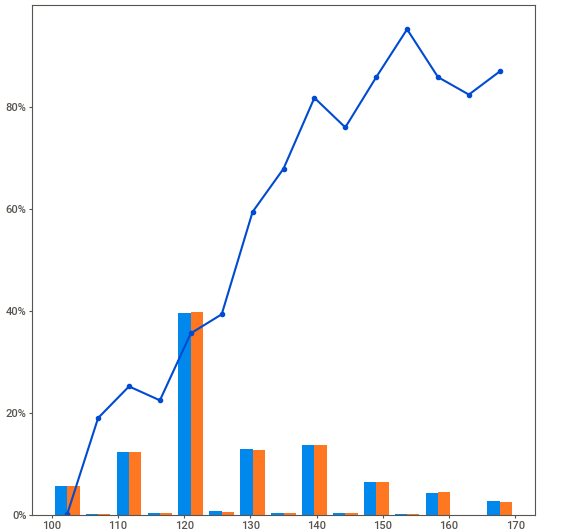
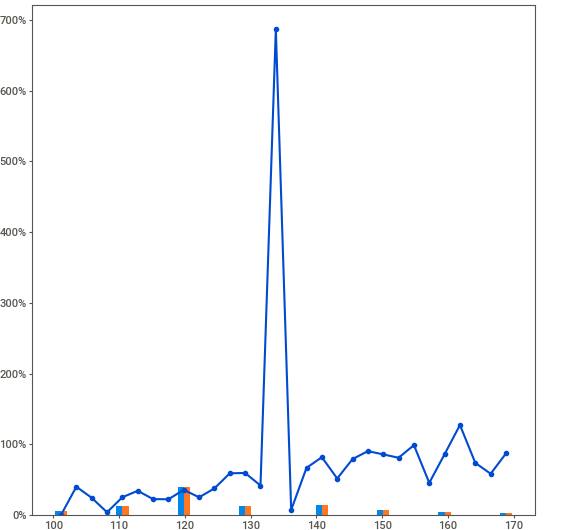
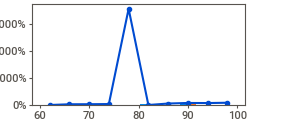
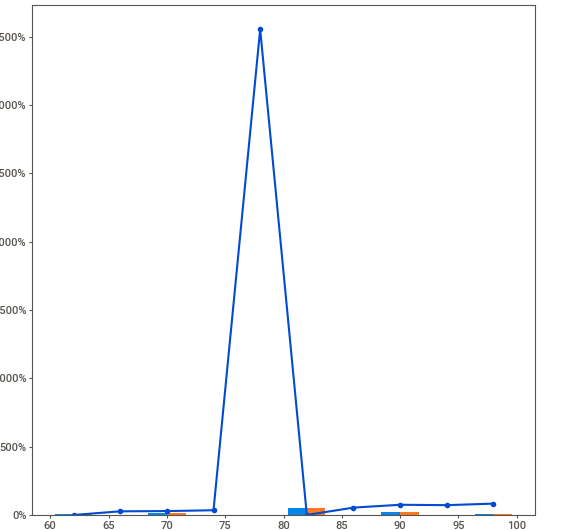
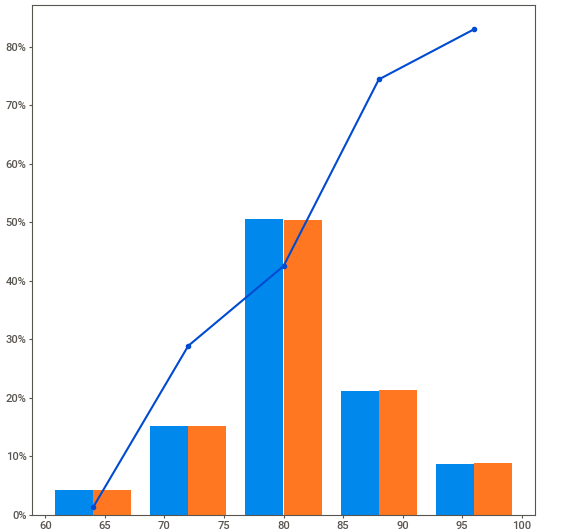
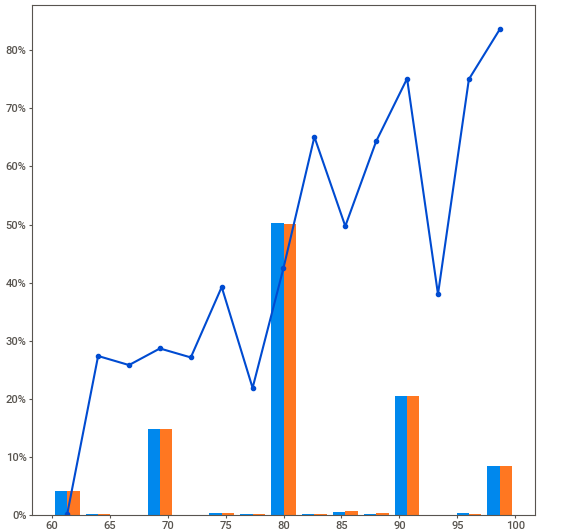
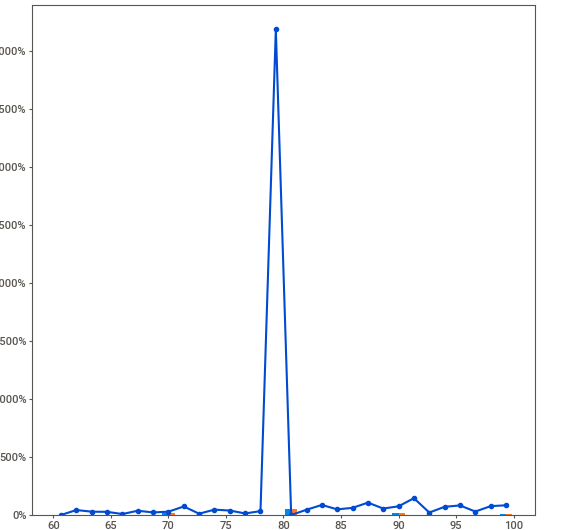
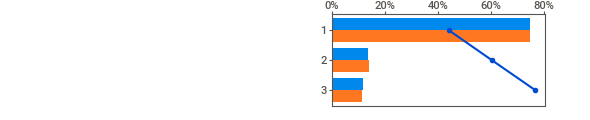
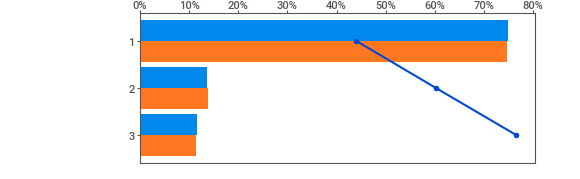
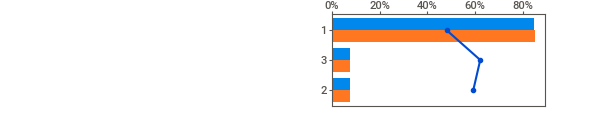
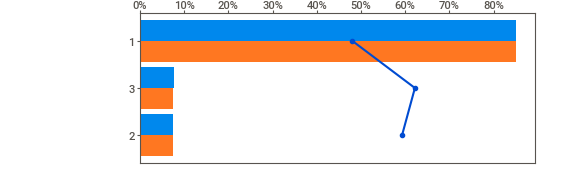
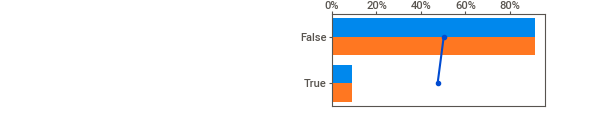
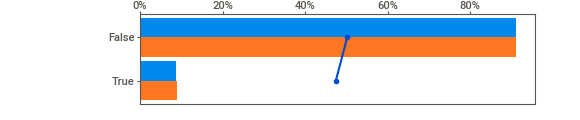
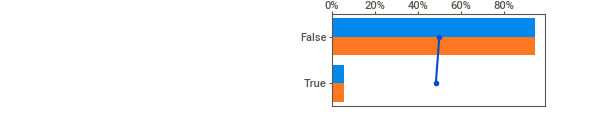
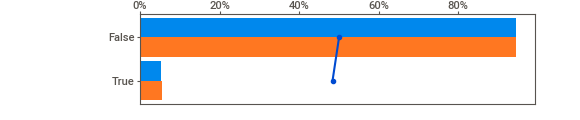
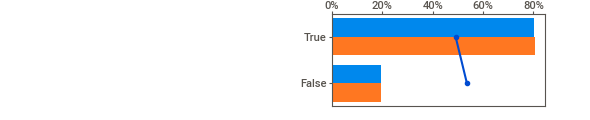
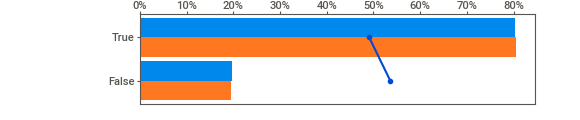
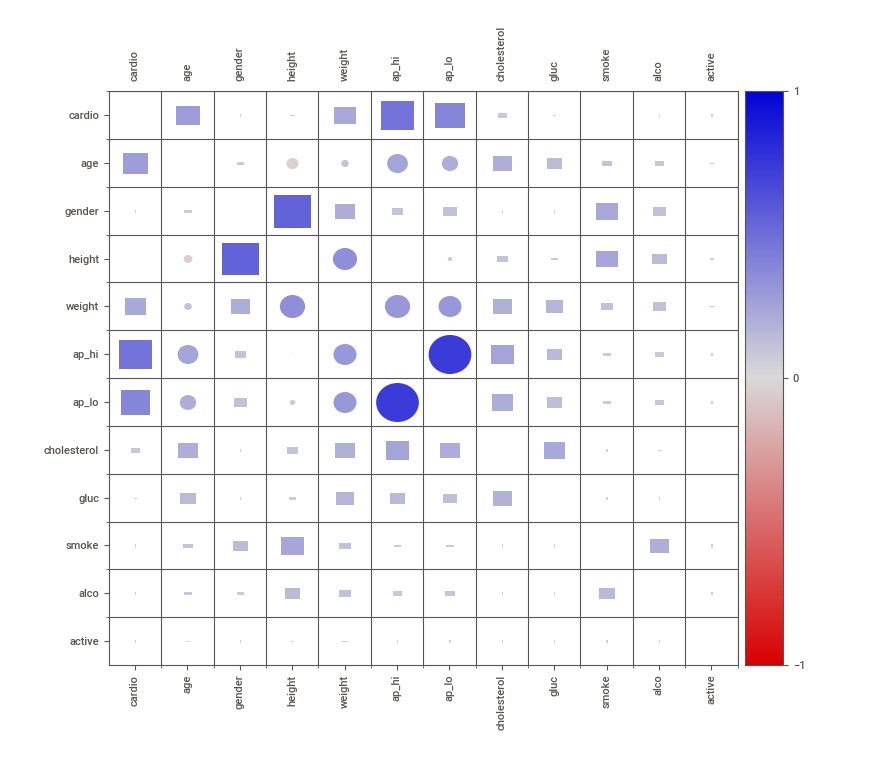
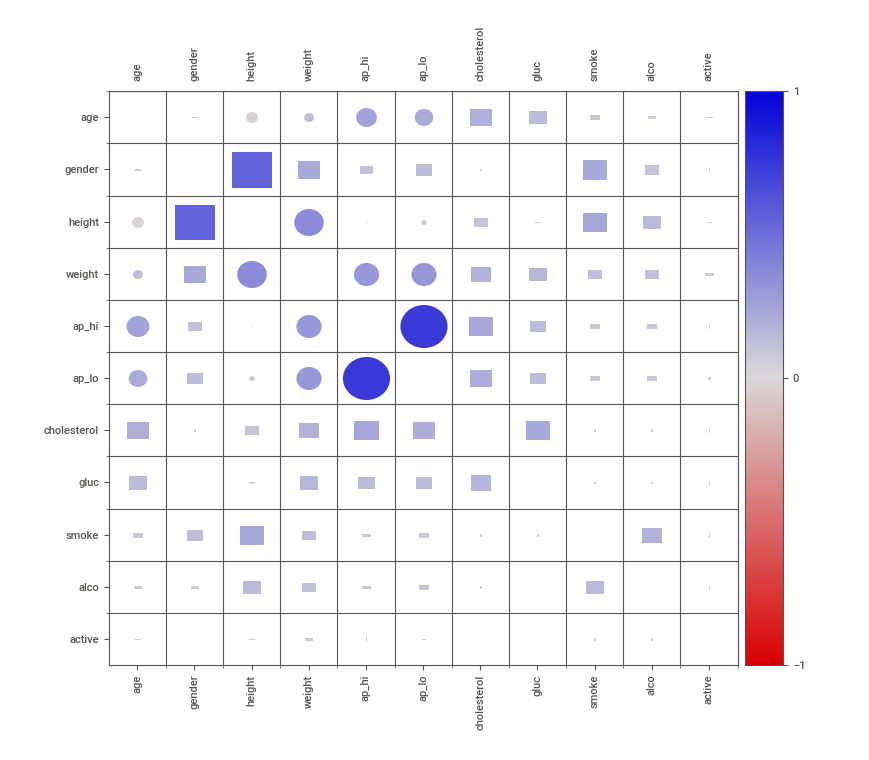

In [9]:
report = sv.compare([train_out_corr, 'heart_diseases_train'], [test_out_corr, 'heart_diseases_test'], target_feat=target)
report.show_notebook()

После исследовательского анализа данных можно видеть, что наибольшее влияние на целевой признак оказывают возраст, вес, давление. Наиболее скоррелированными признаками являются рост и пол, диастолическое и систалическое давление.

In [10]:
# m = TSNE(learning_rate=50, n_jobs=-1)
# tsne_features = m.fit_transform(train_out_corr[num_cols])
# tsne_features = pd.DataFrame(tsne_features, columns=['x_tsne', 'y_tsne'])
# tsne_features.to_csv('tsne/tsne_features_lr50.csv')

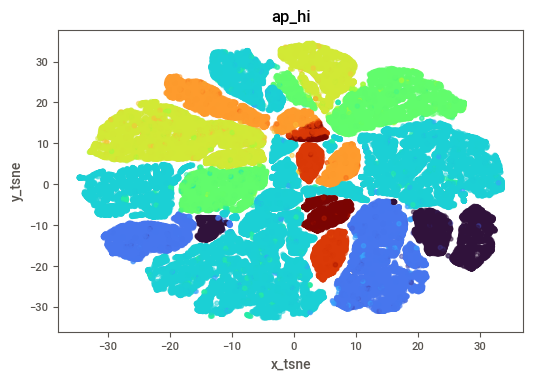

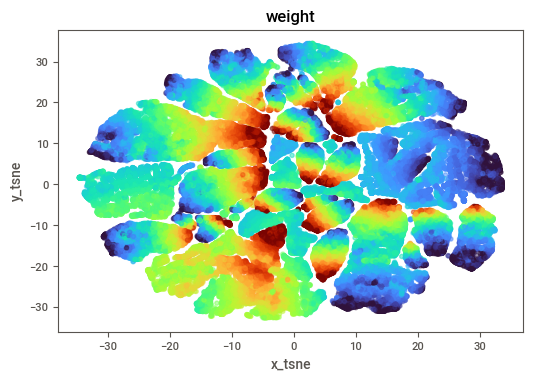

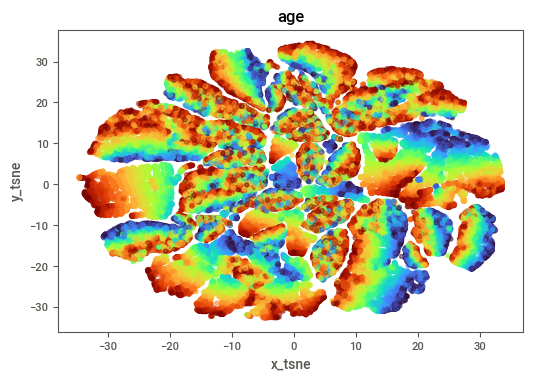

In [11]:
tsne_features = pd.read_csv('tsne/tsne_features_lr50.csv')

for col in ['ap_hi', 'weight', 'age']:
    plt.scatter(x=tsne_features['x_tsne'], y=tsne_features['y_tsne'], 
                c=train_out_corr[[col]].values, alpha=0.5,
                cmap='turbo')
    plt.title(col)
    plt.xlabel('x_tsne')
    plt.ylabel('y_tsne')
    plt.show()